In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
import xarray as xr 

from include.neural_net import NeuralNet

In [2]:
# Load the Covid data
Covid_data = pd.read_csv("../../data/Covid_raw/Berlin_data/data.csv", index_col=0)
Covid_data.index = pd.to_datetime(Covid_data.index)

In [3]:
Covid_data.columns

Index(['susceptible', 'infected', 'recovered', 'deceased'], dtype='object')

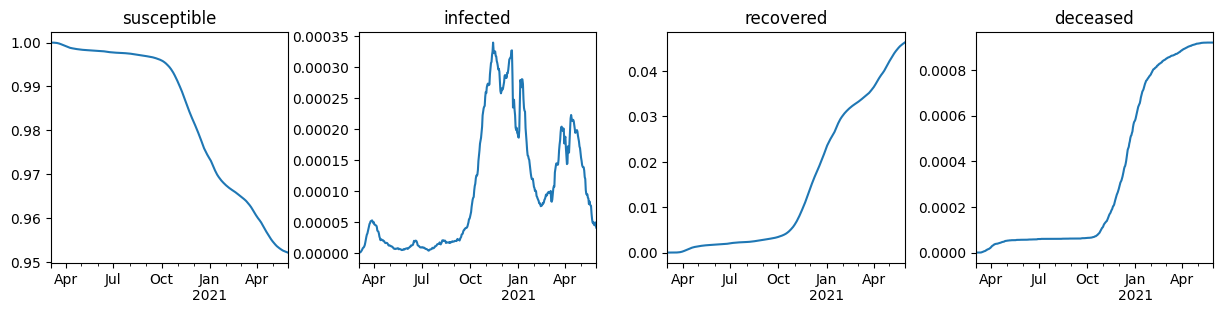

In [27]:
fig, axs = plt.subplots(ncols=4, figsize=(15, 3), gridspec_kw=dict(wspace=0.3))
for idx, col in enumerate(Covid_data.columns):
    Covid_data[col].plot(ax=axs[idx], title=col)

In [185]:
# Split into a training and test/prediction set
training_data, test_data = torch.from_numpy(Covid_data.values).float()[:302], torch.from_numpy(Covid_data.values).float()[302:]
alpha = training_data.sum(dim=0)**(-1)
training_data.shape, test_data.shape, alpha.shape

(torch.Size([302, 4]), torch.Size([152, 4]), torch.Size([4]))

In [150]:
# Define a simple SIR model
def SIR_model(state: torch.Tensor, parameters: dict) -> torch.Tensor:
    new_state = state + torch.stack([- parameters['k_I'] * state[0] * state[1], 
                                      + parameters['k_I'] * state[0] * state[1] - (parameters['k_R'] + parameters['k_D']) * state[1],
                                      + parameters['k_R'] * state[1],
                                      + parameters['k_D'] * state[1]
                                ]) * parameters['dt']
    return new_state

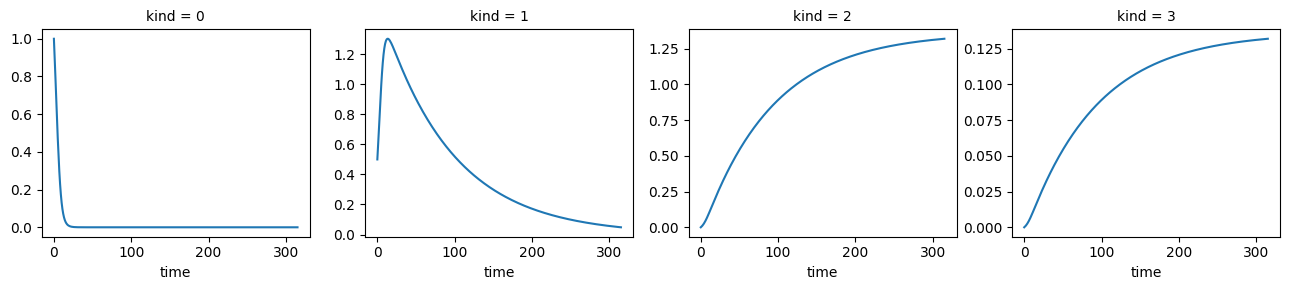

In [184]:
# Small example of the SIR model 
data = [training_data[0] + torch.tensor([0, 0.1, 0, 0])]
for n in range(training_data.shape[0]):
    data.append(SIR_model(data[-1], parameters=dict(k_I=2, k_R=0.1, k_D=0.01, dt=0.1)))
xr.DataArray(data, dims=["time", "kind"]).plot(col="kind", sharey=False)

In [430]:
# Initialise the neural network
NN = NeuralNet(
    input_size=training_data.shape[1],
    output_size=3, #learn three parameters
    num_layers=5,
    nodes_per_layer=dict(default=20),
    activation_funcs=dict(default='sigmoid', layer_specific={0: 'softplus', -1: 'softplus'}),
    biases=dict(default=[-1, 1])
)

loss_ts = []

In [431]:
pred_param = []

In [437]:
# Train
n_epochs = 1000
batch_size = 50
write_every = 10
parameters = dict(dt=0.1)

for e in (pbar := tqdm.tqdm(range(n_epochs))):
    
    # Run the model, stopping to update the estimates every n steps
    predicted_data = [training_data[0].clone()]
    start_idx = 0
    epoch_loss = []
    _pred_param = []
    
    for t in range(training_data.shape[0]):
        
        predicted_parameters = NN(training_data[t])
        if e % write_every == 0:
            _pred_param.append(predicted_parameters.clone().detach())
        
        predicted_data.append(SIR_model(predicted_data[-1], 
                                        parameters={'k_I': predicted_parameters[0], 'k_R': predicted_parameters[1], 'k_D': predicted_parameters[2], 'dt': torch.tensor(0.1)}))

        if t > 0 and (len(predicted_data) % batch_size == 0):
            
            loss = (
                alpha * ((torch.stack(predicted_data)[1:, :] - training_data[start_idx+1:start_idx+len(predicted_data), :])**2).sum(dim=0)
            ).sum(dim=0)
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            start_idx = t
            epoch_loss.append(loss.detach())
            if t < training_data.shape[0] - 1:
                predicted_data = [training_data[t+1].clone()]
    if e % write_every == 0:
        pred_param.append(_pred_param)
    loss_ts.append(np.mean(epoch_loss))
    pbar.set_description(f"Loss: {loss_ts[-1]}")

Loss: 9.31958948058309e-06:  81%|████████  | 810/1000 [01:23<00:19,  9.67it/s]  


KeyboardInterrupt: 

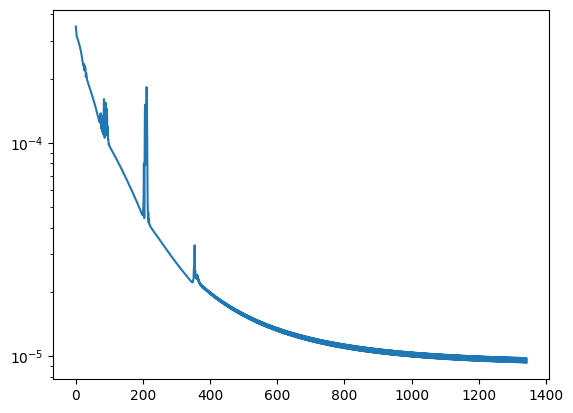

In [438]:
fig, ax = plt.subplots()
ax.plot(loss_ts)
ax.set_yscale('log')

In [439]:
preds = torch.stack([torch.stack(x) for x in pred_param])
preds.shape

torch.Size([135, 302, 3])

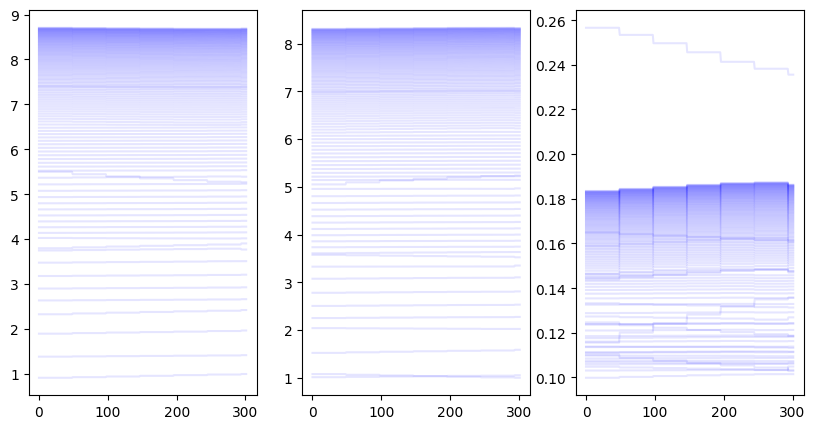

In [440]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
for p in preds:
    for idx, arr in enumerate(p.transpose(0, 1)):
        axs[idx].plot(arr, alpha=0.1, color='blue')

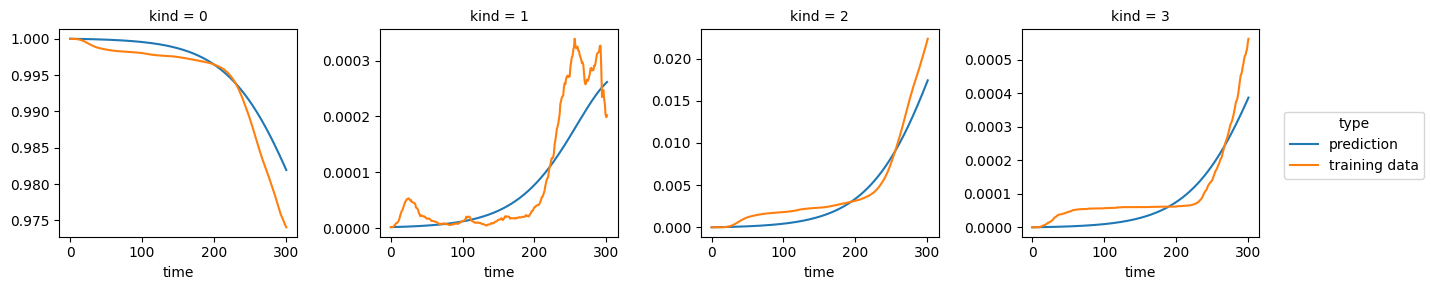

In [441]:
predicted_data = [training_data[0]]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    predicted_data.append(SIR_model(predicted_data[t], 
                                    parameters={'k_I': predicted_parameters[0], 'k_R': predicted_parameters[1], 'k_D': predicted_parameters[2], 'dt': torch.tensor(0.1)}))
xr.concat([
    xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}), 
    xr.DataArray(training_data, dims=["time", "kind"]).expand_dims({'type': ['training data']})], dim='type').plot(col="kind", hue='type', sharey=False)